# 7장. 물류 네트워크 최적 설계
앞서 6장에서는 창고(W)에서 공장(F)으로의 운송 비용을 최소화하는 최적화 문제를 풀었다.  
이 문제는 비교적 간단한 문제이지만, 전체 네트워크에 대한 최적화 문제를 풀려면 다소 복잡해진다. 7장에서는 좀 더 복잡한 최적화 문제를 풀어보자.  
이 회사의 **제조에서 물류까지의 전체 흐름 중 어디에 비용 개선 가능성이 있는지**를 풀어본다.

## [7-1번] Tech 61. 운송 최적화 문제 풀기
- `pulp`: 최적화 모델 작성
- `ortoolpy`: 목적 함수 생성

---
이걸 하려면 우선 아나콘다 프롬프트에서 `pip install pulp`, `pip install ortoolpy` 설치 후 이용할 수 있다.  
그런데 나의 경우에는 이렇게 하면 에러가 떠서,,, 다음의 코드를 쓰면 됨!(캡쳐본 참고)  
`conda install -c conda-forge pulp`, `conda install-c conda-forge ortoolpy` 띄어쓰기 주의

In [1]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals 

In [2]:
#데이터 불러오기
df_tc = pd.read_csv('7장/trans_cost.csv', index_col = '공장') #W-F 이동 시 발생하는 운송비용 -> 앞으로 이걸 최소화하는 게 목적 
df_demand = pd.read_csv('7장/demand.csv') #공장(F)의 최소한의 필요 수요량
df_supply = pd.read_csv('7장/supply.csv') #창고(W)의 최대 가능 공급량 

display(df_tc, df_demand, df_supply)

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [3]:
#초기 설정
np.random.seed(1)
nw = len(df_tc.index) #W 창고 개수 : 3
nf = len(df_tc.columns) #F 공장 개수 :4
pr = list(product(range(nw), range(nf))) #product 함수는 W(0~2)와 F (0~3)넘버를 중복 없이 짝지어줌 

print(pr)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [4]:
#수리 모델 작성
m1 = model_min() #목적 함수. 현재 초기화됨. -> 목적은 최소화! (이후 제약조건을 추가할 것임)
v1 = {(i, j) : LpVariable('v%d_%d'%(i, j), lowBound=0) for i, j in pr} # dict 형식으로 앞서 정의한 pr에서 아이템을 하나씩 뽑아, 이름을 지어줌.
                                                                                                                        #예를 들어 pr의 (0, 0)에 대해선 -> v(문자) 0_0 (v0_0이 되는 것) : 정규표현식임!! 
print(m1)
print(v1)

NoName:
MINIMIZE
None
VARIABLES

{(0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3}


- `lowBound` 인자: 하한선을 설정함. 반대로 `upBound`는 상한을 설정한다. 그래서 v1 인자 값은 최소 0 이상이라는 뜻--어차피 수요 or 공급값은 최소 0 이상이므로 이렇게 설정해도 됨 

In [5]:
print(len(pr), len(v1)) #그래서 둘의 개수는 12개로 똑같다.

12 12


In [6]:
v1[0,0] #v1에는 W 번호, F 번호를 하나씩 넣어 인덱싱이 가능하다. 

v0_0

In [7]:
lpSum(df_tc.iloc[0][0] * v1[0,0]) #v1에서 (창고, 공장) 짝지은 것과 이에 대응하는 비용 곱의 합 
                                                                #-> 구하는 이유? 이 경로에서의 비용, 수요(or 공급)량 곱을 구해서 나중에 최적화에 이용하려고!
    #운송 시 비용이 너무 큰데 필요한 수요(공급)이 적으면 굳이 안 가도 되겠지. 수요(공급)이 많다면 다른 것과 값을 비교해서 필요하다면 갈거고. 
    #가장 좋은 것은 수요(공급)이 큰데 비용이 작은 경우겠지. 이 경우를 찾아서 얘를 늘리는 것이 최적화. 
    #우리는 m1 값 minimize가 목표이므로 비용이 가장 적은 케이스를 찾을거야. 수요(공급)의 제약조건 하에서!

10*v0_0 + 0

In [8]:
#목적함수(m1)에 제약조건 추가하기

m1 += lpSum(df_tc.iloc[i][j] * v1[i,j] for i, j in pr) #아깐 None 이었는데 값이 추가되었다.

## 창고(W) - 창고별 총 공급량 <= 창고가 공급할 수 있는 최대량
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
    
## 공장(F)- 공장별 총 수요량 >= 공장에서 필요로 하는 최소수요
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
    
m1.solve() #최적해 구해줘!

1

In [9]:
# 결과 
print(m1)

NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0
SUBJECT TO
_C1: v0_0 + v0_1 + v0_2 + v0_3 <= 35

_C2: v1_0 + v1_1 + v1_2 + v1_3 <= 41

_C3: v2_0 + v2_1 + v2_2 + v2_3 <= 42

_C4: v0_0 + v1_0 + v2_0 >= 28

_C5: v0_1 + v1_1 + v2_1 >= 29

_C6: v0_2 + v1_2 + v2_2 >= 31

_C7: v0_3 + v1_3 + v2_3 >= 25

VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous



`solve` 메서드를 통해 주어진 제약조건 2개 하에서 최적화 결과를 보여준다.  
결과를 보면 `subject to` 부분에 제약식이 잘 담겼다. 목적함수 m1을 최적화시켰으니, 최적화했을 때의 총비용이 어떻게 달라졌는가를 살펴보자.  

In [10]:
v1.items()

dict_items([((0, 0), v0_0), ((0, 1), v0_1), ((0, 2), v0_2), ((0, 3), v0_3), ((1, 0), v1_0), ((1, 1), v1_1), ((1, 2), v1_2), ((1, 3), v1_3), ((2, 0), v2_0), ((2, 1), v2_1), ((2, 2), v2_2), ((2, 3), v2_3)])

In [11]:
print(v1.keys())
print(v1.values())

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)])
dict_values([v0_0, v0_1, v0_2, v0_3, v1_0, v1_1, v1_2, v1_3, v2_0, v2_1, v2_2, v2_3])


In [12]:
v1[(0,0)]

v0_0

앞서 목적함수 m1을 `solve` 메서드를 사용해서 최적해를 구해달라고 했다. 이제 pulp 라이브러리가 뽑아 준 최적값(optimal value)와 최적해(optimal solution)을 출력해보자.  

--- 
이 문제에서는 최적값은 목적함수 m1을 최소화시키기 위한 최소의 비용 (최소의 총 운송비용)을 이야기한다.   
최적해는 앞서 설정한 v1 의 최적의 값(운송 물품수)을 의미한다.  참고: https://gazelle-and-cs.tistory.com/89  
이 문제에서는 제약조건 하에서 m1을 최소화시키기 위한 운송 비용을 찾는 것이 목표이다.  

- 최적값, 최적해는 pulp 라이브러리의 `value` 함수를 활용하면 구할 수 있다. 
    - value(m1.objective)은  m1이 최소일 때의 값을 구해준다.  -> 최적값 optimal value
    - value(v1)은 m1이 최소가 되는 v1의 값을 구해준다. -> 최적해 optimal solution (나중에 네트워크-엣지의 가중치로도 사용)

In [13]:
for i in v1.values():
    print(i)
    print(value(i)) #당연한 말이지만 여기서 value 함수는 딕셔너리를 뜻하는 게 아님
                                #pulp 라이브러리의 value 함수 -> 최적화 후의 달라진 운송비용 결과를 보여줌 

v0_0
28.0
v0_1
7.0
v0_2
0.0
v0_3
0.0
v1_0
0.0
v1_1
0.0
v1_2
31.0
v1_3
5.0
v2_0
0.0
v2_1
22.0
v2_2
0.0
v2_3
20.0


In [14]:
# 총 운송 비용 계산#
df_tr_sol = df_tc.copy()
total_cost = 0

for k,x in v1.items():
    i,j = k[0],k[1] 
    df_tr_sol.iloc[i][j] = value(x) #구해진 최적해 (v1)
    total_cost += df_tc.iloc[i][j]*value(x) #최적화 이후 총 비용값 (이는 원래비용 * 최적해(v1) = 최적값 )
    
display(df_tr_sol) #최적해
print("총 운송 비용(최적값):", total_cost) #총 운송비용 (최적값)

,F1,F2,F3,F4
공장,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


총 운송 비용(최적값): 1296.0


총 운송비용은 1296만원으로, 6장에서 계산한 총 운송비용인 1433만원보다 더 비용이 절감되었다. (최적값을 잘 구했다!)  
참고로 6장에서 총운송비용을 구할땐 `운송비용(df_tc) * 운송 물품수(df_tr, 운송 경로 데이터)`로 하나씩 대응시켜서 곱의 합을 구했었다.  
여기서는 `운송비용(df_tc) * 최적해`로 구했다고 보면 된다. 이 때의 최적해는 총운송비용을 minimize 시키는 최적의 운송 물품수(운송량)이다.  
결과로 나온 위의 df_tr_sol(최적해) 결과를 보니, 특정 W-> F 경로에 몰빵하도록 물품수를 배치하는 것이 비용을 최소화시키는 것으로 보인다.

In [15]:
value(m1.objective) #최적값 (optimal value)

1296.0

In [16]:
v1 #최적해 (optimal solution) -> 이 자체로는 값이 안 나옴, value(v1)으로 찾아야 함

{(0, 0): v0_0,
 (0, 1): v0_1,
 (0, 2): v0_2,
 (0, 3): v0_3,
 (1, 0): v1_0,
 (1, 1): v1_1,
 (1, 2): v1_2,
 (1, 3): v1_3,
 (2, 0): v2_0,
 (2, 1): v2_1,
 (2, 2): v2_2,
 (2, 3): v2_3}

## Tech 62. 위에서 구한 최적 운송 경로를 네트워크 시각화하자
F,W의 좌표 정보를 가져와 찍고, 운송경로의 최적해(v1)를 가중치로 보면 되겠지?  
우리가 앞서 구한 비용을 최소화시킨 최적값을 네트워크로 나타내면 6장에서 봤던 것과 어떻게 달라지는지를 확인해보자.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#데이터 불러오기
df_tr = df_tr_sol.copy() #가중치이자 최적해(v1)
df_pos = pd.read_csv('7장/trans_route_pos.csv') #좌표

display(df_tr, df_pos)

,F1,F2,F3,F4
공장,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


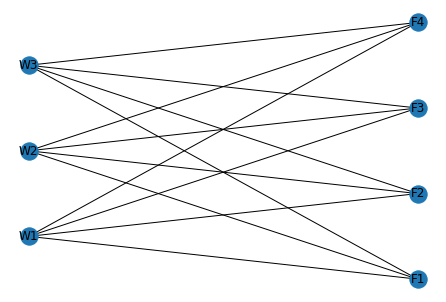

In [18]:
########### 가중치 반영 전 ############## (코드는 6장에서 쓴거랑 동일함)
#객체
G = nx.Graph()

#노드 설정(W 3개, F 4개)
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
#엣지 설정(W에서 하나 - F에서 하나를 연결)
for i in range(0, 3):
    for j in range(3, len(df_pos.columns)):
        G.add_edge(df_pos.columns[i], df_pos.columns[j])
        
#좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
#그리기
nx.draw(G, pos, with_labels=True)
plt.show()

In [19]:
####### 가중치 추가 ########

sy = []
size = 0.1 #가중치 값이 너무 커서 줄임 (그대로 쓰면 엣지가 엄청 굵게나옴)
for i in range(len(df_tr.index)):
    for j in range(len(df_tr.columns)):
        sy.append(df_tr.iloc[i,j]*size)
        
sy

[2.8000000000000003,
 0.7000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 3.1,
 0.5,
 0.0,
 2.2,
 0.0,
 2.0]

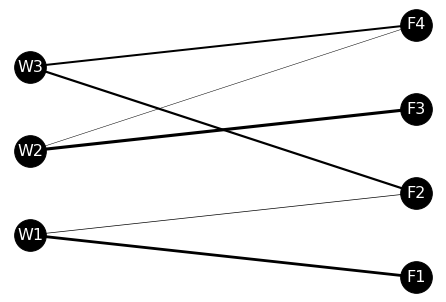

In [20]:
#그래프 다시 그리기
nx.draw(G, pos, with_labels=True,
               font_size = 16, node_size = 1000, node_color = 'k', font_color= 'w', width = sy) #width에 가중치 리스트 설정
plt.show()

6장에서 한 것과 비교해보면 얇은 선이 사라지고, 대신 굵은 선은 더 굵어졌다. ->즉, 집중할 데에 더 집중하고, 집중할 필요 없는 경로는 아예 없앴다.  
결과를 보면 W1 -> F1, W2 -> F3, W3 -> F4, F2 로의 공급이 대부분이다.  
*운송 경로는 어느 정도 집중돼야 한다.* 는 가설이 최적화 계산에 의해 밝혀졌다!

## Tech 63. 구한 최적 운송 경로가 제약 조건도 만족하는지 확인하자
6장에서 작성했던 제약조건 계산 함수를 그대로 가져와, 위에서 구한 운송경로가 제약조건도 만족하는지를 확인하자.

In [21]:
#필요한 데이터
import pandas as pd
import numpy as np

df_demand = pd.read_csv('7장/demand.csv')
df_supply = pd.read_csv('7장/supply.csv')

display(df_demand, df_supply)

,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [22]:
## 6장에서 만든 함수 그대로 가져옴 
#제약조건 함수화 -> 앞서 만든 if문에서, 수요(or 공급)을 만족하면 1, 아니면 0을 출력하도록 하는 flag를 만든다.
## 먼저 0으로 초기화시키고, 만족하는 경우엔 1을 넣어주기 

## 공장(F)의 수요
def c_demand(df_tr, df_demand):
    
    #초기화
    flag = np.zeros(len(df_demand.columns))
    
    #계산
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if temp_sum >= df_demand.iloc[0][i]:
            flag[i] = 1
    
    return flag

## 창고(W)의 공급
def c_supply(df_tr, df_supply):
    
    #초기화
    flag = np.zeros(len(df_supply.columns))
    
    #계산
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
            
    return flag

In [23]:
#수요 계산 결과
c_demand(df_tr_sol, df_demand)

array([1., 1., 1., 1.])

In [24]:
#공급 계산 결과
c_supply(df_tr_sol, df_supply)

array([1., 1., 1.])

우리가 최적해(v1)로 구한 df_tr_sol과 수요(df_demand), 공급(df_supply) 데이터를 넣어 결과를 확인해보았다.  
결과가 모두 1로 나온 것으로 보아, 최소수요보다는 많이, 최대공급보다는 적게 상품이 운송되고 있음을 알 수 있다.  

---
이렇게 목적함수와 제약조건만 명확하게 정의할 수 있다면, 최적화 라이브러리를 활용해 간단하게 해답을 찾을 수 있다.  
최적화 문제엔 다양한 종류가 있고, 모든 최적화 문제가 반드시 풀리진 않는다. 하지만 운송최적화처럼 선형 최적화로 정식화할 수 있는 것은 비교적 짧은 시간 내에 정답을 구할 수 있다.

## [7-2] Tech 64. 생산 계획 최적화 문제 풀기
지금까지는 `운송 비용 최적화`를 진행했다. **가장 운송비용을 줄이기 위해 창고-공장 간 이동하는 물품 수를 어떻게 조정할 것인가?** 에 대한 것이었다. 여기서 찾아낸 최적해(optimal solution)가 바로 v1이었고. -> 결과를 바탕으로, 집중할 경로는 더 집중하고 아닌 경로는 덜 집중하는 방법이 좋음을 파악했다.  

이제부터는 `생산 계획 최적화`를 해볼 것이다. 이는 **어떤 제품을, 얼마나 만들 것인가?** 에 대한 계획이다.  

---
- product_plan_material.csv : 제품 제조에 필요한 원료 비율
- product_plan_profit.csv : 제품 이익
- product_plan_stock.csv : 원료의 재고량
- product_plan.csv : 제품의 생산량

In [25]:
import pandas as pd

df_m = pd.read_csv('7장/product_plan_material.csv', index_col = '제품')
df_p = pd.read_csv('7장/product_plan_profit.csv', index_col = '제품')
df_s = pd.read_csv('7장/product_plan_stock.csv', index_col = '항목')
df_plan = pd.read_csv('7장/product_plan.csv', index_col = '제품')

display(df_m, df_p, df_s, df_plan) #각각 제품내 원료비율, 제품당 이익(=판매가-원가), 원료 재고량, 제품 생산량.

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


,이익
제품,
제품1,5.0
제품2,4.0


,원료1,원료2,원료3
항목,,,
재고,40,80,50


,생산량
제품,
제품1,16
제품2,0


In [40]:
df_p.iloc[1][0]

4.0

주어진 데이터는 2개의 제품(제품1, 제품2)을 생산한다. 그리고 이것들을 제조하는 데엔 3개의 원료(원료1, 원료2, 원료3)가 사용된다.  
현재 제품 생산은 이익이 큰 제품1만 생산되고, 제품2는 아예 생산이 안되고 있다. 이익을 높이기 위해선 제품2의 생산량을 늘리는 게 필요하다.  
마찬가지로 목적함수와 제약조건을 정의하고, 제약조건 하 목표를 최대화(최소화)하는 최적값을 찾아보자.

## Tech 65. 목적 함수를 만들자
여기서 사용할 목적함수는 **이익을 계산하는 함수** 이다. 그리고 이 이익을 최대화하는 최적값을 찾는 게 목표가 될 것이다.  
어떻게 총이익을 계산하면 될까? -> 직감적으로 생각해보면 `이익 * 생산량`을 계산하면 된다. 


In [41]:
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        profit += df_profit.iloc[i][0] * df_plan.iloc[i][0] #이익 * 생산량 
    return profit

In [42]:
print('총이익: ', product_plan(df_p, df_plan))

총이익:  80.0


In [43]:
5*16

80

## Tech 66. 생산 최적화 문제를 풀어보자
위에서 `product_plan`이라는 이익 계산 목적함수를 만들었다. 이제 이 목적함수를 **최대화** 하는 최적값과 최적해를 찾아보자.(즉, 이익을 최대화하는 값)  
문제를 푸는 흐름은 앞서 운송 비용 최적화 문제와 비슷하다.  

---
앞서 `총이익 = 제품별 이익*생산량` 이라고 만들었지. 여기서 이익은 df_p에 정해져있다(fix되어 있다). 그럼 우리가 조절할 수 있는 것은? 생산량!  
그래서 이 `생산량` 의 최적값을 최적해(v2, optimal solution)로 만들고 이 최적해일 때의 총 이익(최적값)을 구할 것이다.

In [46]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

In [47]:
m2 = model_max() #목적함수 - 이익 최대화가 목적
v2 = {(i) : LpVariable('v%d'%(i), lowBound = 0) for i in range(len(df_p))} #최적해- 제품별 생산량을 의미 
print(v2)

{0: v0, 1: v1}


In [48]:
#이제 m2에 제약조건을 하나씩 추가해보자.
m2 += lpSum(df_p.iloc[i] * v2[i] for i in range(len(df_p))) #각 제품별 이익*생산량 

for j in range(len(df_m.columns)): #j: 원료 0,1,2 / i: 제품 0, 1
    m2 += lpSum(df_m.iloc[i, j] * v2[i] for i in range(len(df_p))) <= df_s.iloc[:, j] #제약조건: 각 제품에 필요한 생산량*원료합 <= 최대 원료 재고량 
                                                                                                                                                    # 원료의 재고보다 생산량이 더 많으면 안 되니까!

m2.solve() #최적해 구해줘!

1

In [49]:
#이제 pulp 라이브러리가 알아서 구해준 최적해 값을 보자.
df_plan_sol = df_plan.copy()
display(df_plan_sol) #원래 생산계획

for k, x in v2.items():
    df_plan_sol.iloc[k] = value(x) #v2 최적해 
display(df_plan_sol) #최적으로 찾아낸 생산계획 (생산량)

,생산량
제품,
제품1,16
제품2,0


,생산량
제품,
제품1,15
제품2,5


결과를 보면 최적의 생산량(최적해)는 제품2를 5개 더 생산하고, 제품1은 16개에서 1개 줄인 15개를 생산하는 것이라고 나왔다.  
이 최적해를 적용했을 때 최적값(총이익)은 얼마일까?

In [50]:
print(value(m2.objective)) #총이익은 80 -> 95로 늘어남!

95.0


In [53]:
#또는 이렇게 구해도 됨,,
all_profit = 0

for k, x in v2.items():
    all_profit += value(x)* df_p.iloc[k][0]  #최적의 생산량*이익(fixed)
all_profit

95.0

## Tech 67. 최적 생산 계획이 제약조건을 만족하는지 확인하자.
- 최적화 문제를 풀 때 가장 주의할 점은 **최적화 계산을 한 결과를 이해하지 않고 그냥 받아들이면 안 된다** 는 점이다.
- 결과를 이해 없이 그대로 받아들이면, 실제 조건이 조금 바뀌어 예상결과와 달라졌을 때 기대한 효과를 얻을 수 없다.
    - 가장 흔한 경우는 목적함수와 제약조건이 실제와 달라, 계산된 결과도 현실과 안 맞는 경우이다. 그래서 더더욱 `최적화 계산 결과를 이해하는 것`이 필요!

In [54]:
display(df_m, df_s, df_plan)

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


,원료1,원료2,원료3
항목,,,
재고,40,80,50


,생산량
제품,
제품1,16
제품2,0


In [58]:
#여기서는 제약조건으로 규정한 '각 원료의 사용량'이 '재고를 효율적으로 이용하고 있는가'를 알아보자.
    # 이를 위해선 원료의 사용량 <= 최대 재고량을 만족한다면 1, 아니면 0을 출력하는 함수를 만들고, 위에서 뽑은 최적해가 이에 잘 맞는지를 확인한다.

def cond_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns)) #원료 1, 2, 3이 조건을 만족한다면 1, 아니면 0을 넣기 위함. 초기값으로 모두 0을 넣음
    
    for i in range(len(df_material.columns)): #i: 원료(0,1,2)
        temp_sum = 0
        for j in range(len(df_material.index)): #j: 제품(0,1)
            temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j]) #각 원료에 대해 제품의 생산량*제품에 사용량을 곱함 => temp_sum: 각 원료 총사용량
        if (temp_sum <= float(df_stock.iloc[0][i])): #각 원료에 대해 if문을 실행-> 그래서 원료1 뒤엔 다시 temp_sum을 0으로 초기화시키고 원료2에 대해 계산
            flag[i] = 1 
        print(df_material.columns[i] + ' 사용량: ' +str(temp_sum) + ', 재고: ' + str(float(df_stock.iloc[0][i])))
        
    return flag

In [59]:
np.zeros(3)

array([0., 0., 0.])

In [60]:
#출력: 원래의 df_plan 생산계획 하에서는.. -> 원료들의 재고가 너무 많이 남네!! 이걸 써야 돈을 더버는데!
cond_stock(df_plan, df_m, df_s)

원료1 사용량: 16.0, 재고: 40.0
원료2 사용량: 64.0, 재고: 80.0
원료3 사용량: 48.0, 재고: 50.0


array([1., 1., 1.])

In [61]:
#최적화 이후 df_plan_sol 생산계획 하에서는..
cond_stock(df_plan_sol, df_m, df_s)

원료1 사용량: 25.0, 재고: 40.0
원료2 사용량: 80.0, 재고: 80.0
원료3 사용량: 50.0, 재고: 50.0


array([1., 1., 1.])

flag의 값이 모두 1이므로 세 원료는 모두 재고보다 적게 사용되고 있음. -> 즉, 제약 조건이 충족되었다.  
또한 원료2, 3은 재고를 충분히 다 쓰고 있으며 원료1은 아쉽게도 재고보다 많이 남고 있다. 하지만 이전에 비해선 크게 효율적으로 원료를 쓰고 있음!

## [7-3] Tech 68. 물류 네트워크 설계 문제를 풀어보자.
앞서 7-1에선 운송 경로 최적화, 7-2에선 생산 계획 최적화 문제를 풀었지만 실제 현장에서는 이 두가지를 모두 동시에 고려해야 한다.  
그래서 7-3 번에선 이 2개를 모두 최적화한 문제, 물류 네트워크를 설계하는 문제를 풀어보자.  

---
상품의 수요가 이미 결정되어 있다면 비용을 낮추는 것이 가장 중요한 문제일 것. 그러므로,  
- 목적함수: 비용(운송비용+ 제조비용) 을 최소화
- 제약조건: 각 대리점의 판매수 >= 각 대리점별 최소수요   

여기선 ortoolpy 라이브러리의 `logistics_network`를 이용해 최적설계를 진행한다.

In [78]:
import numpy as np
import pandas as pd

제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

print(제품, 대리점, 공장, 레인)

['A', 'B'] ['P', 'Q'] ['X', 'Y'] (2, 2)


In [79]:
# 대리점 - 공장 간 운송비용
trans_cost = pd.DataFrame( ((j,k) for j in 대리점 for k in 공장), columns = ['대리점', '공장'])
trans_cost['운송비'] = [1,2,3,1]
trans_cost

,대리점,공장,운송비
0,P,X,1
1,P,Y,2
2,Q,X,3
3,Q,Y,1


In [80]:
# 각 대리점에서의 제품 수요량
s_demand = pd.DataFrame( ((j, i) for j in 대리점 for i in 제품), columns = ['대리점', '제품'])
s_demand['수요량'] = [10, 10, 20, 20]
s_demand

,대리점,제품,수요량
0,P,A,10
1,P,B,10
2,Q,A,20
3,Q,B,20


In [81]:
# 각 공장에서의 제품 생산비용(하한: 최소생산량, 상한: 최대생산량)
supply_cost = pd.DataFrame( ((k, l, i, 0, np.inf) for k, nl in zip(공장, 레인)  #k는 공장 (X,Y), nl은 range(레인 수)이므로 0,1 -> zip을 통해 짝지은 것 2개씩 반환 
                                                                              for l in range(nl)
                                                                              for i in 제품), columns = ['공장', '레인', '제품', '하한', '상한'])
supply_cost['생산비'] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]

supply_cost.dropna(inplace=True)
supply_cost.loc[4, '상한'] = 10 #4번 인덱스만 상한 설정 
supply_cost

,공장,레인,제품,하한,상한,생산비
0,X,0,A,0,inf,1.0
3,X,1,B,0,inf,1.0
4,Y,0,A,0,10.0,3.0
6,Y,1,A,0,inf,5.0
7,Y,1,B,0,inf,3.0


In [82]:
from ortoolpy import logistics_network
_, trans_cost2, _ = logistics_network(s_demand, trans_cost, supply_cost, 
                                                       dep = '대리점', dem = '수요량', fac = '공장', prd = '제품', tcs = '운송비', pcs = '생산비',
                                                        lwb = '하한', upb = '상한')

display(supply_cost, trans_cost2)

C:\Users\user\anaconda3\lib\site-packages\ortoolpy\etc.py:1217: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  [tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1


,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000061,20.0
3,X,1,B,0,inf,1.0,v000062,10.0
4,Y,0,A,0,10.0,3.0,v000063,10.0
6,Y,1,A,0,inf,5.0,v000064,0.0
7,Y,1,B,0,inf,3.0,v000065,20.0


,대리점,공장,운송비,제품,VarX,ValX
0,P,X,1,A,v000053,10.0
1,P,X,1,B,v000054,10.0
2,Q,X,3,A,v000055,10.0
3,Q,X,3,B,v000056,0.0
4,P,Y,2,A,v000057,0.0
5,P,Y,2,B,v000058,0.0
6,Q,Y,1,A,v000059,10.0
7,Q,Y,1,B,v000060,20.0


이렇게 logistics_network 라이브러리를 활용하면, 최적해(optimal solution)이 다음과 같이 나온다.   
- `supply_cost`의 ValY: 최적 생산량
- `trans_cost2`의 ValX: 최적 운송량
이 저장된다.  

이제 Tech 69, 70에서 이 결과가 타당한지 검증해보자.

## Tech 69. 최적 운송량 검증

In [83]:
#보기 쉽게 데이터프레임 재구성 (tc2 데이터) 
tc2 = trans_cost2[['공장', '대리점', '운송비', '제품', 'VarX', 'ValX']]
tc2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000053,10.0
1,X,P,1,B,v000054,10.0
2,X,Q,3,A,v000055,10.0
3,X,Q,3,B,v000056,0.0
4,Y,P,2,A,v000057,0.0
5,Y,P,2,B,v000058,0.0
6,Y,Q,1,A,v000059,10.0
7,Y,Q,1,B,v000060,20.0


In [84]:
#이 최적의 운송량(ValX)일 때의 총 운송비용은? -> ValX와 운송비를 곱하면 되겠지?
trans_cost = 0
for i in range(len(tc2.index)):
    trans_cost += tc2['운송비'].iloc[i]*tc2['ValX'].iloc[i]

print(trans_cost)

80.0


In [99]:
#운송량을 시각화하기 위해 임의로 공장-> 대리점으로 간 운송량만 더해본다. (사실 어떤 제품을 생산했는지까지 고려해야 하는데 그냥 간단히 보는 목적이니까 생략)
tc3 = pd.DataFrame(tc2.groupby(['공장', '대리점'], as_index=False)['ValX'].sum())
tc3

,공장,대리점,ValX
0,X,P,20.0
1,X,Q,10.0
2,Y,P,0.0
3,Y,Q,30.0


In [100]:
for i in range(0,2):
    for j in range(2,4):
        print(sy[i], sy[j])

X P
X Q
Y P
Y Q


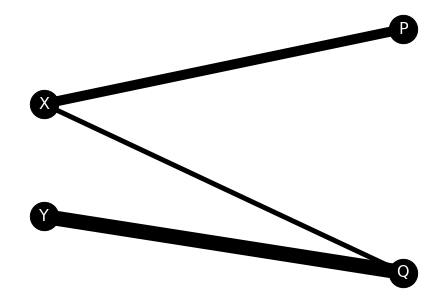

In [105]:
#네트워크 가시화하기
import networkx as nx
import matplotlib.pyplot as plt

#그래프 객체 설정
G = nx.Graph()

#노드 설정
sy = ['X', 'Y', 'P', 'Q']
for i in range(len(sy)):
    G.add_node(sy[i])

#엣지 설정(공장에서 하나 - 대리점에서 하나를 연결)
for i in range(0,2):
    for j in range(2,4):
        G.add_edge(sy[i], sy[j])

#엣지 가중치 리스트화
size = 0.5 #가중치 사이즈 축소 
sy2 = []
for i in range(len(tc3.index)):
    sy2.append(tc3['ValX'].iloc[i] *size)
    
        
#좌표 설정(정보가 없어 내가 임의로 설정함)
pos = {}
pos['X'] = (0, 0.9)
pos['Y'] = (0, 0.3)
pos['P'] = (0.7,1.3)
pos['Q'] = (0.7, 0)

#그리기
nx.draw(G, pos, with_labels=True,
               font_size = 16, node_size = 800, node_color= 'k', font_color = 'w', width = sy2) #가중치는 width 옵션으로 지정 
plt.show()

In [106]:
print(sy2)

[10.0, 5.0, 0.0, 15.0]


결과를 보면 총 운송 비용은 `80만원` 이다. 내역을 보면 운송비가 적은 X-> P, Y-> Q 등의 경로에 운송량이 많이 배치되었다.  
좌표정보가 없어 임의로 설정했고, networkx 라이브러리를 활용해 엣지를 ValX로 하여 시각화해보았다. 시각화를 하니 어디로 운송량이 많이 배치되었는지 파악하기가 용이하다!

## Tech 70. 최적 생산량 검증

In [85]:
supply_cost

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000061,20.0
3,X,1,B,0,inf,1.0,v000062,10.0
4,Y,0,A,0,10.0,3.0,v000063,10.0
6,Y,1,A,0,inf,5.0,v000064,0.0
7,Y,1,B,0,inf,3.0,v000065,20.0


In [87]:
#이 최적의 생산량(ValY)일 때 총 생산비용은? -> ValY와 생산비를 곱하면 되겠지?
product_cost = 0
for i in range(len(supply_cost.index)):
    product_cost += supply_cost['생산비'].iloc[i]*supply_cost['ValY'].iloc[i]

print(product_cost)

120.0


결과를 보면 총 생산 비용은 `120만원` 이다.  
생산비용이 낮은 공장 X에서의 생산량을 늘렸고,  공장 Y에선 레인 1 사용시 생산비용이 5로 높아 아예 생산하지 않고, 대신 레인 0에서 10개를 생산하였다.  

사실 생산 비용 데이터만 보면 공장 X가 생산비용이 적으므로 공장X에서만 생산하면 좋지 않나? 싶지만, 우리는 운송 비용까지 고려해야 함을 잊지말자.  
공장 Y에서 대리점까지의 운송비용이 공장X에서 대리점까지의 운송비용보다 낮은 경우가 있기 때문에 우리는 공장 Y에서도 생산을 일부 해야 한다. (그래서 결과적으로 공장 Y에서는 A 생산을 10, B 생산을 20 하는 것이 최적의 생산량으로 도출되었다.)

### 정리
이렇게 하여 7장에서의 물류 네트워크 최적화 작업을 마친다. 라이브러리를 활용해 비교적 수월하게 최적화 문제를 풀 수 있었지만, **이 결과를 그대로 받아들이면 큰코다친다.**  
여기서 배운 내용은 제대로 최적화가 이루어졌는가를 확인하는 최소의 작업일 뿐이다.  
무엇을 조사하고 확인할 것인가는 현장에 따라 다르며, 중요한 것은 결과를 그대로 받아들이지 않고 항상 의심하며 현장의 업무를 개선해나가는 자세이다!  

---
다음 8장에서는 물류 데이터가 아닌, 소비자의 입소문에 의한 행동 데이터로 분석을 해본다.  
인간관계 네트워크를 시각화하고, 수치 시뮬레이션이라는 데이터 분석 기법을 바탕으로 미래를 예측해본다. 정말 재미있을 듯! +_+